<h1>Euler's method</h1>

<p>Consider $x'(t) = a - b x(t)$. Suppose we try and solve <em>numerically</em></p>

<p>We do this by find a table of values $(t_0, x(t_0))$, $\dots$, $(t_0 + nh, x(t_0+nh))$.</p>

<p>Well, what to do for the first one – we need $x(t_0 + h)$?</p>

<p>If we <em>approximate</em> we might have $x(t_0 + h) \approx x(t_0) + x'(t_0) \cdot h$. <em>But</em>, we have then $x(t_0+h) \approx x(t_0) + h \cdot f(t_0, x(t_0))$ so we can actually compute this:</p>

In [1]:
a,b = 1, 1//2
f(t, x) = a - b*x^2
t0, x0 = 0, 1
h = 1/10
n = 10
ts = Float64[t0]
xs = Float64[x0]

for i in 1:n
  ti, xi = ts[end], xs[end]

  xi1 = xi + f(ti, xi) * h

  push!(ts, ti + h)
  push!(xs, xi1)
end

<p>Our table:</p>

In [1]:
[ts xs]

11×2 Array{Float64,2}:
 0.0  1.0    
 0.1  1.05   
 0.2  1.09488
 0.3  1.13494
 0.4  1.17053
 0.5  1.20203
 0.6  1.22978
 0.7  1.25416
 0.8  1.27552
 0.9  1.29417
 1.0  1.31043

<p>Our plot</p>

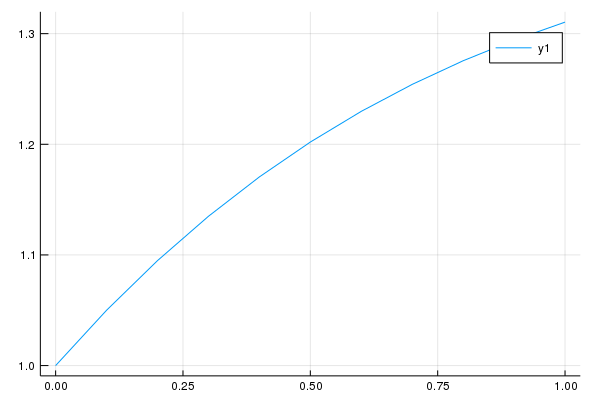

In [1]:
using Plots
plot(ts, xs)

<p>How does this compare to the actual answer?</p>

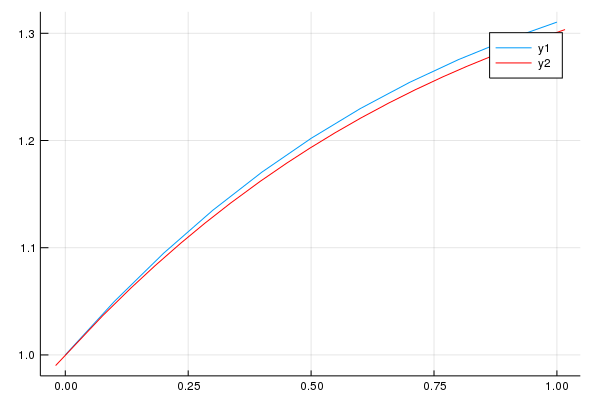

In [1]:
using SymPy
u = SymFunction("u")
@vars t
eqn = dsolve(u'(t) - f(t, u(t)), t, (u, t0, x0))[1]
fn = lambdify(real(rhs(eqn)))
plot!(fn, color=:red)

<p>Not too bad. Could we do better?</p>

<p>Would more points help?</p>

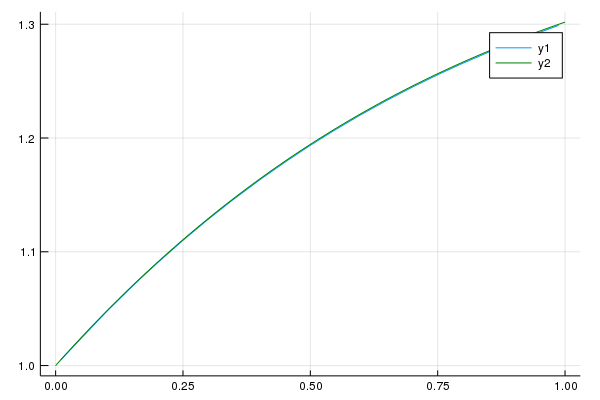

In [1]:
h = 1/100
n = 100

ts = Float64[t0]
xs = Float64[x0]

for i in 1:n
  ti, xi = ts[end], xs[end]

  xi1 = xi + f(ti, xi) * h

  push!(ts, ti + h)
  push!(xs, xi1)
end

plot(fn, 0, 1)
plot!(ts, xs, color=:green)

<p>So yes, more points would help.</p>

<p>But more points <strong>could</strong> mean floating point errors might creep in. So we would need to be mindful of:</p>

<ul>
<li><p>the mathematical error used in truncating using $x(t+h) = x(t) + x'(t) h$ on each step</p>
</li>
<li><p>the <em>accumulated</em> truncation error used in this truncation</p>
</li>
<li><p>the floating point error in each step</p>
</li>
<li><p>the <em>accumulated</em> floating point error in each step</p>
</li>
<li><p>The total error.</p>
</li>
</ul>

<p>What can we do improve? One way is to use more terms in the Taylor Series for $x(t+h)$:</p>

<ul>
<li><p>the truncation error on each step is $x^{(n+1)}(\xi)/(n+1)! \cdot h^{n+1}$ so <em>should</em> get smaller as $n$ gets bigger if $\mathcal{O}(h^{n+1})$.</p>
</li>
<li><p>More accuracy will let us use fewer steps to achieve the overall same total accuracy</p>
</li>
<li><p>More work!</p>
</li>
</ul>

<p>Let's see by using $T_4$:</p>


$$
x(t+h) = x(t) + x'(t) h + x''(t)h^2/2! + x'''(t) h^3/3! + x''''(t)h^4/4!.
$$


<p>What is $x''(t)$?</p>


$$
x''(t) = [x'(t)]' = [f(t,x)]' = [a - b\cdot x(t)^2]' =
-2bx(t) \cdot x'(t).
$$


<p>And $x'''(t) = [x''(t)]'$:</p>


$$
x'''(t) = [-2bx(t) \cdot x'(t)]= -2b[x'(t)^2 + x(t) \cdot x''(t)].
$$


<p>Finally,</p>


$$
x''''(t) = -2b[x'(t)^2 + x(t) \cdot x''(t)]' =
-2b[2x'(t)\cdot x''(t) + x'(t) \cdot x''(t) + x(t) \cdot x'''(t)].
$$


<p>Armed with this, we can now compute a step and iterate this:</p>

In [1]:
h = 1/10
n = 10
xs = Float64[x0]
ts = Float64[t0]
for i in 1:n
  ti, xi = ts[end], xs[end]

  xpi = f(t0, xi)
  xppi = -2b*xi*xpi
  xpppi = -2b*(xpi^2 + xi * xppi)
  xppppi = -2b*( 2xpi * xppi + xpi * xppi + xi * xpppi)
  xi1 = xi + xpi*h/1 + xppi*h^2/2 + xpppi*h^3/6 + xppppi * h^4 / 24

  push!(ts, ti + h)
  push!(xs, xi1)
end

<p>We can visualize with</p>

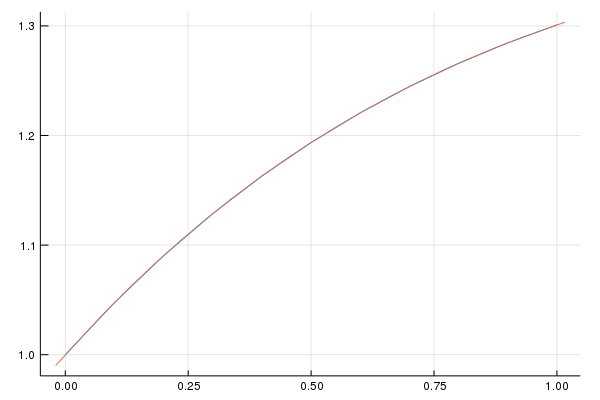

In [1]:
plot(ts, xs, legend=false)
plot!(fn)

<p>Notationally, we can write the following for the $n+1$st term in the Taylor polynomial</p>


$$
x_{[n+1]} = \frac{f_{[n]}}{n!},
$$


<p>emphasizing that the $n+1$ term involves terms with derivatives up to order $n$ coming from differentiating the function $f$.</p>

<h2>Taylor Series Method</h2>

<p>Use a higher order Taylor approximation for $x(t+h)$, repeat for many steps.</p>

<p>Here is a description of a Julia Package <a href="https://github.com/JuliaDiff/TaylorSeries.jl/blob/master/examples/1-KeplerProblem.ipynb">Taylor.jl</a></p>

<p>An interesting application is <a href="https://github.com/PerezHz/TaylorIntegration.jl/blob/master/examples/JuliaCon2017/TaylorIntegration_JuliaCon.ipynb">here</a></p>

<h2>Errors</h2>

<p>We have this description of Euler's method (from <a href="https://en.wikipedia.org/wiki/Euler_method">Wikipedia</a>)</p>

<blockquote>
<p>The Euler method is a first-order method, which means that the local error (error per step) is proportional to the square of the step size, and the global error (error at a given time) is proportional to the step size.</p>
</blockquote>

<p>The <em>local error</em> is proportional to the step size – Why? We have</p>


$$
x(t + h) = x(t) + x'(t) h + \mathcal{O}(h^2).
$$


<p>The global error is propogated through $c/h$ steps, so the errors accumulate to give basically $\mathcal{O}(h)$, or proportional to the step size.</p>

<p>More rigorously, we have with $x^*_i$ being the estimate and assuming Lipschitz:</p>


$$
GTE_{i+1} = |x^*_{i+1} - x_{i+1}| =
|x^*_i- + h \cdot f(t_i, x^*_i) -  (x_{i} + h \cdot f(t_i, x_i) + \mathcal{O}(h^2)| \leq
\delta + (1 + Lh) \cdot |x^*_i - x_i|,
$$


<p>Where $\delta = M/2 h^2$ is a bound on the one-step truncation error $f''(\xi)/2 h^2$.</p>

<p>This iterates to yield (with $\gamma = 1 + Lh$):</p>


$$
GTE_{i+1} \leq \delta + \gamma + GTE_{i} \leq \delta (1 + \gamma + \gamma^2 + \dots + \gamma^k),
$$


<p>With $k = (t - t0)/h$, the number of steps needed to progress to $t$.</p>

<p>But this means</p>


$$
GTE \leq \delta \cdot \frac{1 - \gamma^{(t-t_0)/h}}{1 - \gamma} \leq \frac{M}{2L}(e^{L(t-t_0)} - 1) h.
$$


<p>So we see $\mathcal{O}(h)$.</p>